<a href="https://colab.research.google.com/github/umersajid11/CatDogClassification/blob/main/catdogclassificationusingdataaugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.04G/1.06G [00:04<00:00, 260MB/s]
100% 1.06G/1.06G [00:04<00:00, 232MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os, shutil
from sklearn.model_selection import train_test_split

# Define source folders
base_dir = "/content/train"
cat_dir = os.path.join(base_dir, "cats")
dog_dir = os.path.join(base_dir, "dogs")

# Get image file names
cat_images = [f for f in os.listdir(cat_dir) if f.endswith('.jpg')]
dog_images = [f for f in os.listdir(dog_dir) if f.endswith('.jpg')]

# Split into train and val (90% train, 10% val)
cat_train, cat_val = train_test_split(cat_images, test_size=0.1, random_state=42)
dog_train, dog_val = train_test_split(dog_images, test_size=0.1, random_state=42)

# Create new folder structure
def make_dirs(base_path):
    for subset in ['train', 'val']:
        for label in ['cats', 'dogs']:
            path = os.path.join(base_path, subset, label)
            os.makedirs(path, exist_ok=True)

make_dirs('/content/data')

# Function to move images
def move_images(images, src_folder, dst_folder):
    for img in images:
        src = os.path.join(src_folder, img)
        dst = os.path.join(dst_folder, img)
        shutil.copyfile(src, dst)

# Move cat images
move_images(cat_train, cat_dir, '/content/data/train/cats')
move_images(cat_val, cat_dir, '/content/data/val/cats')

# Move dog images
move_images(dog_train, dog_dir, '/content/data/train/dogs')
move_images(dog_val, dog_dir, '/content/data/val/dogs')


In [ ]:
Data Augmentation

In [18]:
# Preprocessing
image_size = (227, 227)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

In [19]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
#Generator
train_generator = train_datagen.flow_from_directory(
    '/content/data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Since it's binary classification: cat vs dog
)

val_generator = val_datagen.flow_from_directory(
    '/content/data/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [21]:
print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [34]:
# Define the CNN model
model = Sequential()

# 1st Conv Block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001), input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Conv Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Conv Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 227, 227, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 227, 227, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 113, 113, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 113, 113, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,947,649 (49.39 MB)

 Trainable params: 12,947,201 (49.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [38]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 256s 436ms/step - accuracy: 0.5183 - loss: 5.0285 - val_accuracy: 0.5275 - val_loss: 0.8457
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 235s 418ms/step - accuracy: 0.5113 - loss: 0.8215 - val_accuracy: 0.4990 - val_loss: 0.8076
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 262s 419ms/step - accuracy: 0.4966 - loss: 0.8027 - val_accuracy: 0.4985 - val_loss: 0.7880
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 235s 417ms/step - accuracy: 0.5050 - loss: 0.7856 - val_accuracy: 0.5000 - val_loss: 0.7662
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 235s 417ms/step - accuracy: 0.5004 - loss: 0.7607 - val_accuracy: 0.4995 - val_loss: 0.7465
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 234s 416ms/step - accuracy: 0.4936 - loss: 0.7417 - val_accuracy: 0.4990 - val_loss: 0.7298
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 261s 415ms/step - accuracy: 0.4987 - loss: 0.7260 - val_accuracy: 0.4990 - val_loss: 0.7171
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 235s 417ms/step - accuracy: 0.5043 -

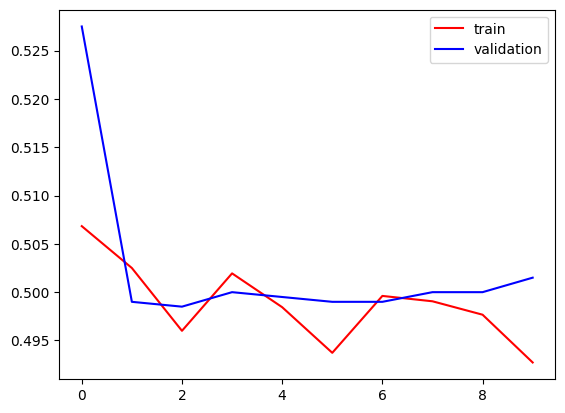

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

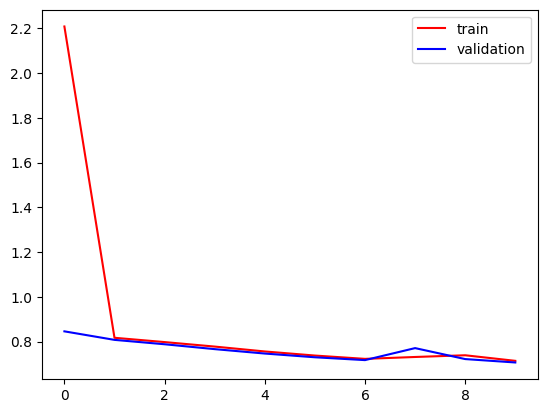

In [40]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
#Way to Reduce Overfitting
#Add More Data
#Data AUgmentation
#L1/L2 Regulizer
#Dropout
#Batch Norm
#Reduce Complexity